<a href="https://colab.research.google.com/github/frnocentini/brain-tumor-object-dectection/blob/main/Brain_tumor_effnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/dataset brain tumor/dataset'


/content/drive/MyDrive/dataset brain tumor/dataset


In [4]:
!unzip 'axial_t1wce_2_class' -d '/dataset unzipped'

Archive:  axial_t1wce_2_class.zip
  inflating: /dataset unzipped/axial_t1wce_2_class/axial_t1wce_2_class.yaml  
   creating: /dataset unzipped/axial_t1wce_2_class/images/
   creating: /dataset unzipped/axial_t1wce_2_class/images/test/
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_101.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_109.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_111.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_117.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_121.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_126.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00018_134.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00019_66.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/images/test/00019_75.jpg  
  inflating: /dataset unzipped/axial_t1wce_2_class/image

In [5]:
!unzip 'coronal_t1wce_2_class' -d '/dataset unzipped'

Archive:  coronal_t1wce_2_class.zip
  inflating: /dataset unzipped/coronal_t1wce_2_class/coronal_t1wce_2_class.yaml  
   creating: /dataset unzipped/coronal_t1wce_2_class/images/
   creating: /dataset unzipped/coronal_t1wce_2_class/images/test/
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/13.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/15.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/17.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/19.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/20.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/23.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/33.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/34.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/35.jpg  
  inflating: /dataset unzipped/coronal_t1wce_2_class/images/test/36.jpg  
  inflating: /d

In [6]:
!unzip 'sagittal_t1wce_2_class' -d '/dataset unzipped'

Archive:  sagittal_t1wce_2_class.zip
   creating: /dataset unzipped/sagittal_t1wce_2_class/images/
   creating: /dataset unzipped/sagittal_t1wce_2_class/images/test/
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_102.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_121.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_140.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00000_159.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_110.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_129.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_147.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00002_166.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00003_154.jpg  
  inflating: /dataset unzipped/sagittal_t1wce_2_class/images/test/00003_173.jpg  
  inflating: /

In [7]:
# Data Manipulation
import numpy as np
import pandas as pd
import os
# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense, Activation
from PIL import Image
# Other
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [8]:
#Codice per rendere l'immagine quadrata 
def make_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.shape[0], im.shape[1]
    size = max(x, y)
    BLACK = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im,int((size-y)/2),int((size-y)/2),int((size-x)/2),int((size-x)/2),cv2.BORDER_CONSTANT, value = BLACK)
    return new_im

In [9]:
%cd '/dataset unzipped'


/dataset unzipped


In [10]:
#Bounding box with one tumor
lab = ['axial_t1wce_2_class','coronal_t1wce_2_class', 'sagittal_t1wce_2_class']
X_train = []
bb = []
temp_array  = []
image_size = 180
for i in lab:
    folderPath = os.path.join('./',i,'images','train')
    for j in sorted(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        print(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
image_index = 0
bb_train = np.zeros((len(X_train),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','train')
    for j in sorted(os.listdir(labelsPath)):
        print(os.path.join(labelsPath,j))
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_train[image_index] = np.array([temp_array])
                #print(bb_train[image_index])
            image_index += 1

X_test = []
for i in lab:
    folderPath = os.path.join('./',i,'images','test')
    for j in sorted(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
image_index = 0
bb_test = np.zeros((len(X_test),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','test')
    for j in sorted(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    #print(k)
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_test[image_index] = np.array([temp_array])
                #print(bb_test[image_index])
            image_index += 1
#print(bb_test.shape[0])

./axial_t1wce_2_class/images/train/00095_170.jpg
./axial_t1wce_2_class/images/train/00095_176.jpg
./axial_t1wce_2_class/images/train/00095_188.jpg
./axial_t1wce_2_class/images/train/00095_200.jpg
./axial_t1wce_2_class/images/train/00095_212.jpg
./axial_t1wce_2_class/images/train/00095_224.jpg
./axial_t1wce_2_class/images/train/00095_226.jpg
./axial_t1wce_2_class/images/train/00095_236.jpg
./axial_t1wce_2_class/images/train/00097_65.jpg
./axial_t1wce_2_class/images/train/00097_68.jpg
./axial_t1wce_2_class/images/train/00097_70.jpg
./axial_t1wce_2_class/images/train/00097_72.jpg
./axial_t1wce_2_class/images/train/00097_74.jpg
./axial_t1wce_2_class/images/train/00097_76.jpg
./axial_t1wce_2_class/images/train/00097_77.jpg
./axial_t1wce_2_class/images/train/00097_79.jpg
./axial_t1wce_2_class/images/train/00097_80.jpg
./axial_t1wce_2_class/images/train/00097_81.jpg
./axial_t1wce_2_class/images/train/00097_83.jpg
./axial_t1wce_2_class/images/train/00099_129.jpg
./axial_t1wce_2_class/images/tr

In [11]:
len(X_train)

878

In [12]:
#prepare dataset 
train_dataset = ImageDataGenerator()
val_dataset = ImageDataGenerator()

In [13]:
#array conversion
X_train = np.array(X_train)
X_test = np.array(X_test)

In [14]:
#Shuffle
X_train, bb_train = shuffle(X_train, bb_train)

In [15]:
#Validation set created
X_train, X_val, bb_train, bb_val = train_test_split(X_train, bb_train, test_size = 0.1, shuffle = False)

In [16]:
BATCH_SIZE = 16
#save_path = os.path.join('./', 'model_effnet')
train_dataset = train_dataset.flow(X_train, bb_train, batch_size = BATCH_SIZE)
val_dataset = val_dataset.flow(X_val, bb_val, batch_size = BATCH_SIZE)

In [17]:
def iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    i = 0;
    results = []
    
    #for i in range(0,y_true.shape[0]):
    
    # set the types so we are sure what type we are using
    #y_true = y_true.astype(np.float32)
    #y_pred = y_pred.astype(np.float32)


    # boxTrue
    boxTrue_width = y_true[0,2]
    boxTrue_height = y_true[0,3]
    x_boxTrue_tleft = y_true[0,0]-boxTrue_width/2  # numpy index selection
    y_boxTrue_tleft = y_true[0,1]-boxTrue_height/2
    
    area_boxTrue = (boxTrue_width * boxTrue_height)

    # boxPred
    boxPred_width = y_pred[0,2]
    boxPred_height = y_pred[0,3]
    x_boxPred_tleft = y_pred[0,0]-boxPred_width/2  
    y_boxPred_tleft = y_pred[0,1]-boxPred_height/2
    
    area_boxPred = (boxPred_width * boxPred_height)


    # calculate the bottom right coordinates for boxTrue and boxPred

    # boxTrue
    x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
    y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

    # boxPred
    x_boxPred_br = x_boxPred_tleft + boxPred_width
    y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


    # calculate the top left and bottom right coordinates for the intersection box, boxInt

    # boxInt - top left coords
    x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
    y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

    # boxInt - bottom right coords
    x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
    y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

    # Calculate the area of boxInt, i.e. the area of the intersection 
    # between boxTrue and boxPred.
    # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
    
    
    # Version 2 revision
    area_of_intersection = \
    np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

    iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


    # This must match the type used in py_func
    #iou = iou.astype(np.float32)
    
        # append the result to a list at the end of each loop
        #results.append(iou)
        #mean = np.mean(results)
    
    # return the mean IoU score for the batch
    return iou

In [26]:
METRIC_THRESH = 0.3

def raw_iou(y_true, y_pred):
    results = []
    for i in range(0,y_true.shape[0]):


        boxTrue_width = y_true[i,2]
        boxTrue_height = y_true[i,3]
        x_boxTrue_tleft = y_true[i,0]-boxTrue_width/2  # numpy index selection
        y_boxTrue_tleft = y_true[i,1]-boxTrue_height/2
    
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        boxPred_width = y_pred[i,2]
        boxPred_height = y_pred[i,3]
        x_boxPred_tleft = y_pred[i,0]-boxPred_width/2  
        y_boxPred_tleft = y_pred[i,1]-boxPred_height/2
    
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = np.mean(area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)).astype(np.float32)


        # This must match the type used in py_func
        results.append(iou)
    return np.mean(results)

def IoU(y_true, y_pred):
    iou = tf.numpy_function(raw_iou, [y_true, y_pred], tf.float32)
    return iou



In [19]:
#def iou(y_true,y_pred):
  #pred_bbox_val = model.predict(X_val)
  #iou = tf.numpy_function(calculate_iou,[y_true,y_pred],tf.float32)
  #return iou

In [27]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, height, width = bbox_coords
        img = cv2.rectangle(img, (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (255, 0, 0), 1)
        #img = cv2.rectangle(img, (0,0),(10,10), (0, 0, 255), 1)
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, height1, width1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-height1/2), int(ymin1-width1/2)), (int(xmin1+height1/2), int(ymin1+width1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [21]:
#To test the model
def test_model(model):
    rand_index = np.random.randint(0, bb_test.shape[0])
    pred_bbox = model.predict(X_test)[rand_index]
    img_original = X_test[rand_index]
    img = img_original.copy()
    coords = bb_test[rand_index]
    #example, label = next(datagen)
    #X = example['image']
    #y = label['coords']
    #pred_bbox = model.predict(X)[0]
    #img = X[0]
    #gt_coords = y[0]
    
    display_image(img,bbox_coords = coords, pred_coords=pred_bbox)

def test(model):
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model)    
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        

In [28]:
callbacks_list = [
    ShowTestImages()
]

In [23]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(4,name='bb_pred')(model)
model = tf.keras.models.Model(inputs=effnet.inputs, outputs = model)
model.summary

16705208/16705208 [==============================] - 1s 0us/step


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f362c202b30>>

In [29]:
model.compile(
    loss={
        'bb_pred': 'mae'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[IoU]
    
)

Epoch 1/5
7/7 [==============================] - 0s 38ms/step


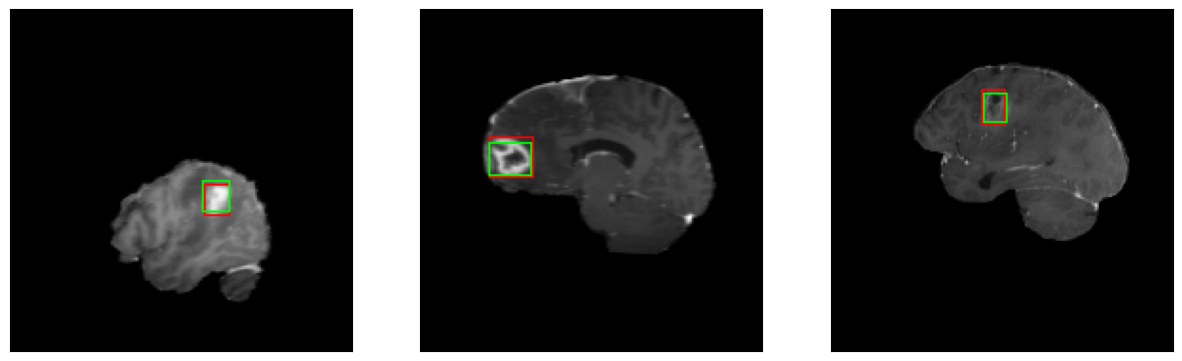

50/50 [==============================] - 7s 137ms/step - loss: 2.0873 - IoU: 0.6095 - val_loss: 2.6147 - val_IoU: 0.6739
Epoch 2/5
7/7 [==============================] - 0s 40ms/step


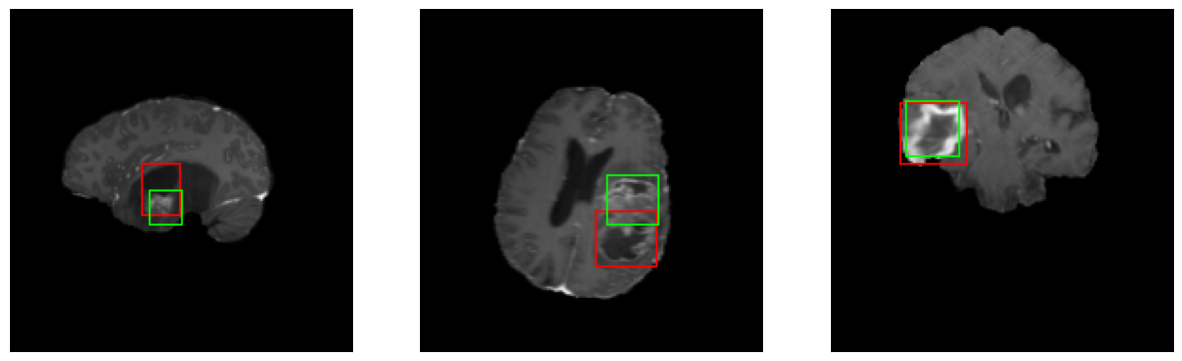

50/50 [==============================] - 7s 134ms/step - loss: 2.1227 - IoU: 0.6057 - val_loss: 2.6950 - val_IoU: 0.6317
Epoch 3/5
7/7 [==============================] - 0s 38ms/step


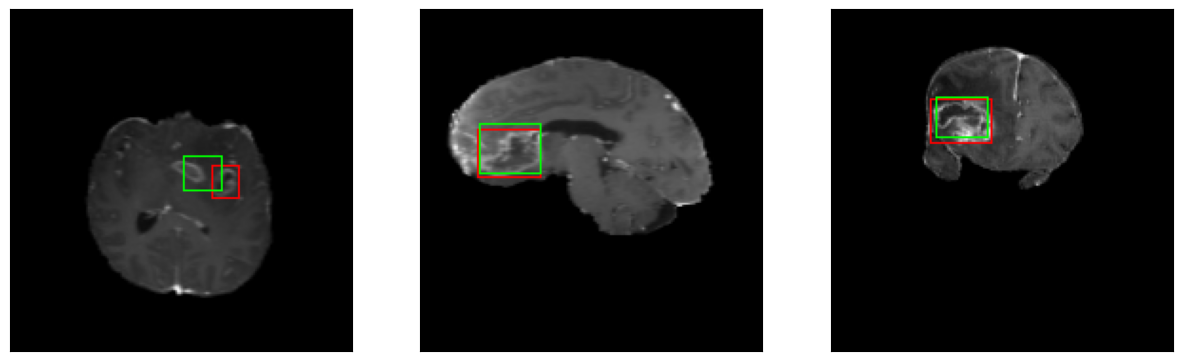

50/50 [==============================] - 7s 133ms/step - loss: 2.2217 - IoU: 0.5934 - val_loss: 3.0039 - val_IoU: 0.5901
Epoch 4/5
7/7 [==============================] - 0s 37ms/step


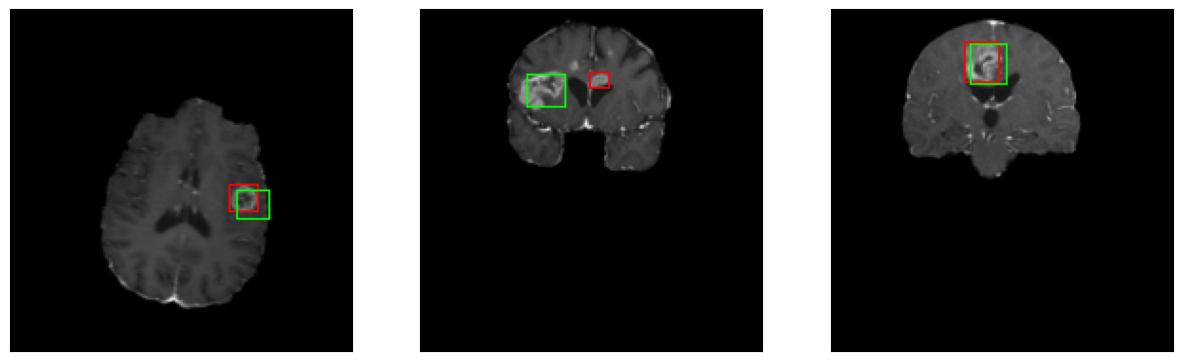

50/50 [==============================] - 7s 141ms/step - loss: 2.1389 - IoU: 0.6007 - val_loss: 2.7077 - val_IoU: 0.6368
Epoch 5/5
7/7 [==============================] - 0s 38ms/step


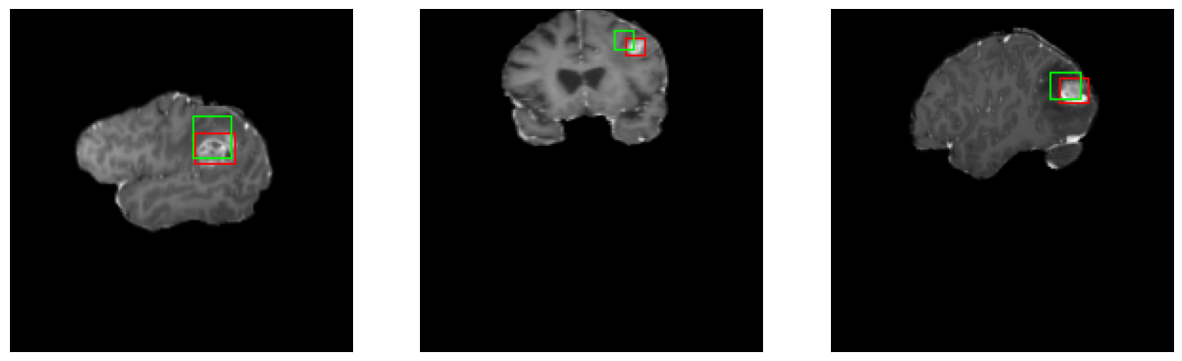

50/50 [==============================] - 7s 134ms/step - loss: 2.2106 - IoU: 0.5979 - val_loss: 3.4183 - val_IoU: 0.5008


In [31]:
model.fit(
        train_dataset,
        epochs=5,
        validation_data = val_dataset,
        callbacks = callbacks_list
        )

In [32]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, height, width = bbox_coords
        img = cv2.rectangle(img, (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (255, 0, 0), 1)
        
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, height1, width1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-height1/2), int(ymin1-width1/2)), (int(xmin1+height1/2), int(ymin1+width1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
